In [1]:
REDUCTION = 'MONTGOMERY' ##### 'MONTGOMERY' or 'PLANTARD'
THS_ID = 0
NSHARES = 1                ##### number of shares in masking scheme (1 for unprotected)
TARGET = 'lowhigh'         ##### 'low' or 'high' or 'lowhigh'
MODEL_STR = 'packed'          #### 'packed', 'signed_hw', 'abs', 'opf'

In [2]:
N_step  = 1             ##### Convergence Step
N_start = 16            ##### Starting number of traces
N_stop  = 40           ##### Ending number of traces (inclusive)

In [3]:
import sys
sys.path.append('../../../../scaredcu/scaredcu')

In [4]:
import scaredcu
import numpy as np
import cupy as cp
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
%matplotlib widget
import util
import math
from itertools import combinations

/home/userfoobar/toluntosun/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/userfoobar/toluntosun/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


In [5]:
cp.cuda.runtime.setDevice(1)

In [6]:
scaredcu.models._HW_LUT = cp.array([0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                     1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                     1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                     2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                     1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                     2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                     2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                     3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 4, 5, 5, 6, 5, 6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8], dtype='uint32')

In [7]:
ths = scaredcu.estraces.ets_format.read_ths_from_ets_file(f'traces/kyber_basemult_{REDUCTION.lower()}_d{NSHARES}_t{THS_ID}.ets')

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
def filename():
    return f'cpa_results/basemult_{REDUCTION.lower()}_d{NSHARES}_t{str(THS_ID)}_{MODEL_STR}_{TARGET}'

In [10]:
n = 128
q = 3329

In [11]:
def poi_filename():
    return f'cpa_results_poi/basemult_{REDUCTION.lower()}_d{NSHARES}_t{str(THS_ID)}_{MODEL_STR}_{TARGET}'

results_max_even = cp.load(f'{poi_filename()}/PoI_even.npy')
results_max_odd = cp.load(f'{poi_filename()}/PoI_odd.npy')


In [12]:
def make_frame_share(key_index, share, offset=0, length=None):
    if REDUCTION == 'MONTGOMERY':
        R = [93, 9189]
        K = 140

    elif REDUCTION == 'PLANTARD':
        R = [128, 9740]
        K = 148
    r = range(R[share] + K*(key_index//2), R[share] + K*(key_index//2) + K)
    if length is None:
        return r[offset:]
    else:
        return r[offset:offset+length]

def make_frame(key_index, offset=0, length=None):
    ranges = [make_frame_share(key_index, share, offset, length) for share in range(NSHARES)]
    return sorted(set().union(*ranges))

def get_relative_poi(Ni, key_index):
    if key_index % 2 == 0:
        if REDUCTION == 'MONTGOMERY' and TARGET == 'high':
            # For the trace set with montgomery reduction, we observe three peaks for the even key index. upon observation, we take the second maximum peak (even_poi = 78).
            # We noticed that, the first maximum peak (even_poi = 81) corresponds to TARGET = 'low'.
            # In other words, instead of (s0,s1), (s1*twiddle,s0) shows peak.
            # This observation can be made by comparing the best scoring predictions for these PoIs.
            # One can also simply repeat the attack for each outstanding peak.
            # The ranks of these PoIs can change depending on the data set so the analyst may need to tune it manually at this point
            temp = results_max_even[(Ni//N_step) - 1].copy()
            temp[80:84] = temp.min()
            return int(temp.argmax().get())
        else:
            return int(results_max_even[(Ni//N_step) - 1].argmax().get())
    else:
        return int(results_max_odd[(Ni//N_step) - 1].argmax().get())
    
def get_poi(Ni, key_index):
    relative_poi = get_relative_poi(Ni, key_index)
    return make_frame(key_index, offset=relative_poi, length=1)

In [ ]:
if REDUCTION == 'MONTGOMERY':
    CORR_NEG = True

elif REDUCTION == 'PLANTARD':
    CORR_NEG = False

In [14]:
if REDUCTION == 'MONTGOMERY':
    basemul_imp = scaredcu.lbc.kyber.base.BaseMulMonty()
elif REDUCTION == 'PLANTARD':
    basemul_imp = scaredcu.lbc.kyber.base.BaseMulPlantard()


# model and selection for the sign
def make_basemul_reverse(key_index, s_):
    if TARGET == 'high':
        low = False
        high = True
    elif TARGET == 'low':
        low = True
        high = False
    elif TARGET == 'lowhigh':
        low = True
        high = True
    @scaredcu.reverse_selection_function
    def basemul_reverse(c):
        return basemul_imp.basemul(c[:, key_index*2 : key_index*2 + 2], s_[cp.newaxis, :], low=low, high=high, frame=[key_index])
    return basemul_reverse

sign_model = scaredcu.models.ShiftRight(15)


In [24]:
def get_sign(ths, key_index, low, high, ):
    reduction = scaredcu.lbc.modop.Reduction_Q2Q2(3329, o_dtype='int16')
    s_ = cp.array([low, high], dtype='int16')
    s_ = reduction.reduce(s_)
    cpa_reverse = scaredcu.CPAReverse(selection_function=make_basemul_reverse(key_index, s_), model=sign_model)
    mean = ths.samples.mean(axis=0)
    frame_poi = get_poi(len(ths), key_index)
    if NSHARES > 1:
        frames = [range(j, (j+1)) for j in range(NSHARES)]
        pp = [scaredcu.preprocesses.high_order.CenteredProductHigh(frames, mean=mean[frame_poi])]
    else:
        pp = []            
                
    container = scaredcu.Container(ths, preprocesses=pp, frame=frame_poi)
    
    cpa_reverse.run(container)
    if CORR_NEG ^ (NSHARES % 2):
        return cpa_reverse.results[0,0] < 0
    else:
        return cpa_reverse.results[0,0] > 0

In [16]:
def succ_ratio(dir_, key, n, q, N_start, N_step, N_stop, accept_neg=True, clear_nan=True, key_prefix='ki', get_sign_func=None, ths=None):
    succs = []

    for key_index in tqdm(range(n)):
        for i in tqdm(range(N_start, N_stop + N_step, N_step)):
            scores_sorted = np.load(f'{dir_}/{key_prefix}_{key_index}_{i}_k.npy')
            guess_low, guess_high = util.unpack_guess(scores_sorted[0], q)
            if accept_neg:
                if (guess_low == key[key_index*2] and  guess_high == key[key_index*2 + 1]) or \
                    ((q - guess_low) == key[key_index*2] and  (q - guess_high) == key[key_index*2 + 1]):
                    succs.append(i)
                    break
            else:
                s = 1 if get_sign_func(ths[:i], key_index, guess_low, guess_high) else -1
                guess_low, guess_high = s*guess_low % q, s*guess_high % q
                if (guess_low == key[key_index*2] and  guess_high == key[key_index*2 + 1]):
                    succs.append(i)
                    break

    succs_np = np.array(succs)
    succ_ratios = []

    for i in tqdm(range(N_start, N_stop + N_step, N_step)):
        succ_ratios.append((succs_np <= i).sum() / n)

    return succ_ratios

In [25]:
succs = succ_ratio(filename(), ths.s[0], n, q, N_start, N_step, N_stop, accept_neg=False, get_sign_func=get_sign, ths=ths)

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [26]:
succs

[0.328125,
 0.5,
 0.625,
 0.7109375,
 0.78125,
 0.8046875,
 0.84375,
 0.8984375,
 0.9296875,
 0.953125,
 0.9609375,
 0.984375,
 0.984375,
 0.9921875,
 0.9921875,
 0.9921875,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

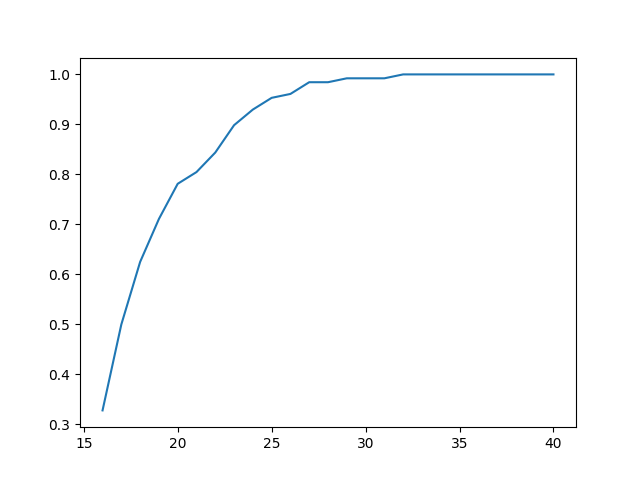

In [27]:
fig, ax = plt.subplots()

x_range = [i for i in range(N_start, N_stop + N_step, N_step)]

ax.plot(x_range, succs)

In [28]:
for x,y in zip(x_range,succs):
    print(f'({x},{y})',end='')

(16,0.328125)(17,0.5)(18,0.625)(19,0.7109375)(20,0.78125)(21,0.8046875)(22,0.84375)(23,0.8984375)(24,0.9296875)(25,0.953125)(26,0.9609375)(27,0.984375)(28,0.984375)(29,0.9921875)(30,0.9921875)(31,0.9921875)(32,1.0)(33,1.0)(34,1.0)(35,1.0)(36,1.0)(37,1.0)(38,1.0)(39,1.0)(40,1.0)

In [42]:
### functions for estimating lattice attack outcome


def read_K(dir_, key, n, q, N, accept_neg=True, key_prefix='ki', get_sign_func=None, ths=None, mode=0):
    x = []

    for key_index in tqdm(range(n)):
        scores = np.load(f'{dir_}/{key_prefix}_{key_index}_{N}_v.npy')
        scores_sorted = np.load(f'{dir_}/{key_prefix}_{key_index}_{N}_k.npy')
        guess_low, guess_high = util.unpack_guess(scores_sorted[0], q)
        if accept_neg:
            if (guess_low == key[key_index*2] and  guess_high == key[key_index*2 + 1]) or \
            ((q - guess_low) == key[key_index*2] and  (q - guess_high) == key[key_index*2 + 1]):
                check = True
            else:
                check = False
        else:
            s = 1 if get_sign_func(ths[:N], key_index, guess_low, guess_high) else -1
            guess_low, guess_high = s*guess_low % q, s*guess_high % q
            if (guess_low == key[key_index*2] and  guess_high == key[key_index*2 + 1]):
                check = True
            else:
                check = False
        score = scores[0]

        if mode == 0:
            score = scores[0]
        elif mode == 1:
            score = (scores[0] - (scores[1:].mean()))

        x.append((check, score, key_index)) 

    return sorted(x, key=lambda tup: tup[1]), x


def get_conv(dir_, key_index, key_prefix, N):
    scores = np.load(f'{dir_}/{key_prefix}_{key_index}_{N}_v.npy')
    return scores

def draw_sorted(sorted_x, colored=True):

    fig,ax = plt.subplots()
    ctr = 0
    r_ctr = 0
    r_max = 0
    for tup in sorted_x:
        ctr += 1
        if tup[0] == True:
            if colored:
                ax.scatter(ctr, tup[1],color='g')
            else:
                ax.scatter(ctr, tup[1],color='b')
        else:
            if colored:
                ax.scatter(ctr, tup[1],color='r')
            else:
                ax.scatter(ctr, tup[1],color='b')                
            print(tup[2],end=',')
            r_ctr += 1
            r_max = ctr
    print()
    print(ctr - r_ctr, r_max)


def count_true(sorted_x):
    ctr = 0
    for e in sorted_x:
        if e[0]:
            ctr += 1
    return ctr


def num_trials(sorted_x, K=38, max_L=128):
    ctr = 1
    for L in range(K, max_L + 1):
        combs = list(combinations(sorted_x[::-1][:L], K))[math.comb(L-1, K):]
        for A in combs:
            #sub_x = sorted_x[::-1][A]
            if count_true(A) >= K:
                return ctr
            else:
                ctr += 1
    return -1


def to_x2(x):
    x2 = []
    for key_index in tqdm(range(len(x)//2)):
        x2.append((x[2*key_index][0] and x[2*key_index+1][0],x[2*key_index][1]*x[2*key_index+1][1],key_index)) 

    return sorted(x2, key=lambda tup: tup[1]), x2

In [41]:
math.comb(43, 38)

962598

In [31]:
sorted_x, x = read_K(filename(), ths.s[0], n, q, N=19, accept_neg=False, ths=ths, mode=1, get_sign_func=get_sign)


  0%|          | 0/128 [00:00<?, ?it/s]

In [32]:
print(x)

[(False, 0.025056958, 0), (True, 0.03607732, 1), (True, 0.042944193, 2), (True, 0.02301389, 3), (True, 0.040860236, 4), (False, 0.017899275, 5), (True, 0.051080287, 6), (True, 0.017466724, 7), (True, 0.017907023, 8), (True, 0.04766333, 9), (True, 0.057214558, 10), (False, 0.034217477, 11), (False, 0.037677824, 12), (False, 0.020279884, 13), (True, 0.03424996, 14), (True, 0.056922257, 15), (False, 0.02192527, 16), (True, 0.029529393, 17), (False, 0.01905036, 18), (True, 0.040004373, 19), (True, 0.04245895, 20), (True, 0.039191604, 21), (True, 0.045962214, 22), (True, 0.04879588, 23), (True, 0.05197555, 24), (False, 0.01824361, 25), (False, 0.04518038, 26), (True, 0.03567344, 27), (False, 0.017011285, 28), (True, 0.03932023, 29), (False, 0.03447354, 30), (True, 0.049457908, 31), (False, 0.0199309, 32), (False, 0.020965159, 33), (False, 0.025128782, 34), (True, 0.01944989, 35), (False, 0.045466185, 36), (True, 0.04197997, 37), (True, 0.025986552, 38), (True, 0.048819482, 39), (False, 0.00

40,82,61,66,110,65,121,48,115,116,28,74,127,86,101,5,25,125,123,54,18,32,13,33,16,49,0,34,76,105,56,87,59,120,77,95,113,63,11,30,44,12,69,42,26,36,
82 100


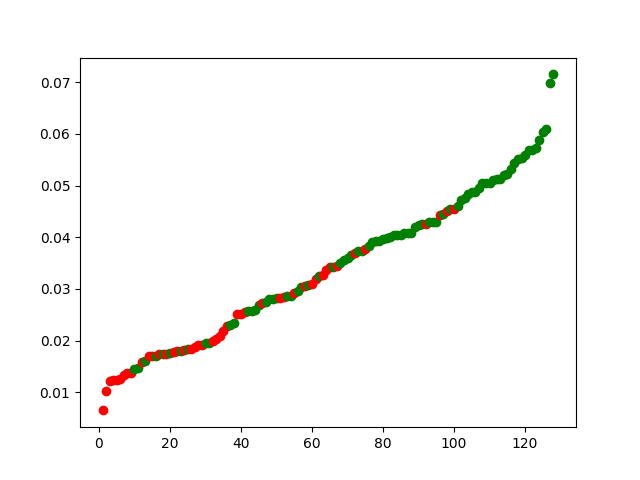

In [33]:
draw_sorted(sorted_x, colored=True)

In [34]:
num_trials(sorted_x, K=38, max_L=42)

962598

In [43]:
num_trial_arr = []

for Ni in tqdm(range(N_start, N_stop + N_step, N_step)):
    sorted_x, x = read_K(filename(), ths.s[0], n, q, N=Ni, accept_neg=False, ths=ths, mode=1, get_sign_func=get_sign)
    num_trial_arr.append(num_trials(sorted_x, K=38, max_L=43))

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

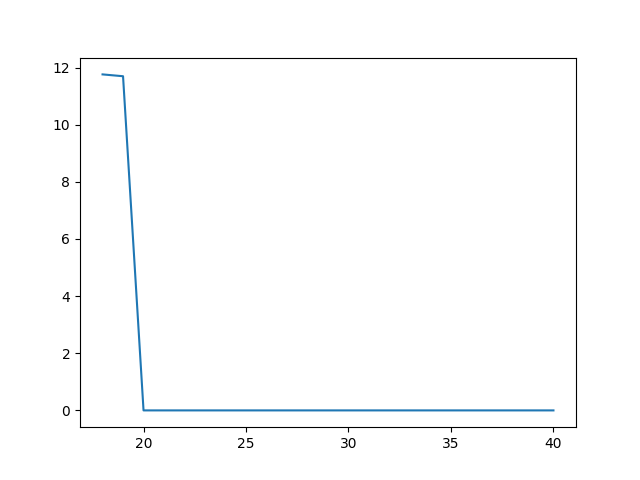

In [47]:
fig, ax = plt.subplots()

start = 0
while(num_trial_arr[start] == -1):
    start += 1

x_range = [i for i in range(N_start, N_stop + N_step, N_step)]

ax.plot(x_range[start:], [math.log(x) for x in num_trial_arr[start:]])

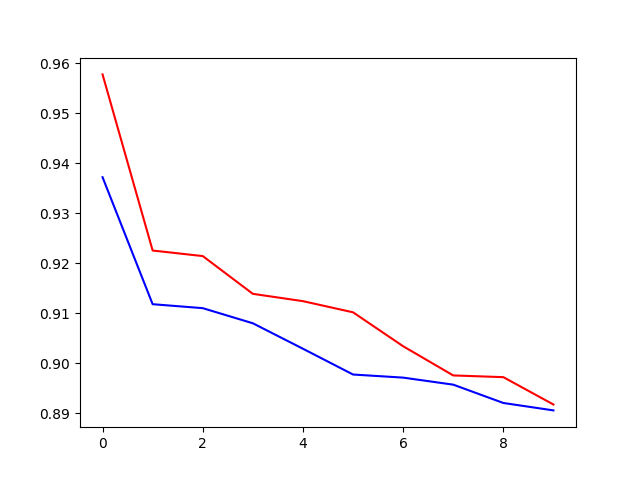

In [106]:
conv = get_conv(filename(), 3, 'ki', N=18)

conv2 = get_conv(filename(), 49, 'ki', N=18)

fig, ax = plt.subplots()

ax.plot(conv, color='blue')

ax.plot(conv2, color='red')

In [13]:
if MODEL_STR == 'packed':
    model = scaredcu.models.PackedHammingWeight(expected_dtype='int16')
elif MODEL_STR == 'signed_hw':
    model = scaredcu.models.SignedHammingWeight(expected_dtype='int16')
elif MODEL_STR == 'abs':
    model = scaredcu.models.AbsoluteValue()
elif MODEL_STR == 'opf':
    model = scaredcu.lbc.OPFTableReduction(scaredcu.lbc.modop.Reduction_Q2Q2(q=3329, dtype='int16'),
                                           fix0=False, d=NSHARES)

In [14]:
def get_prediction_scores(dir_, key, n, N, accept_neg=False, key_prefix='ki', ths=None):
    prediction = []
    scores_ = []
    checks = []

    for key_index in tqdm(range(n)):
        scores = np.load(f'{dir_}/{key_prefix}_{key_index}_{N}_v.npy')
        scores_sorted = np.load(f'{dir_}/{key_prefix}_{key_index}_{N}_k.npy')
        scores_.append(scores[0])
        guess_low, guess_high = util.unpack_guess(scores_sorted[0], q)
        if (guess_low == key[key_index*2] and  guess_high == key[key_index*2 + 1]) or \
        (accept_neg and ((q - guess_low) == key[key_index*2] and  (q - guess_high) == key[key_index*2 + 1])):
            check = True
        else:
            check = False
        if (accept_neg and ((q - guess_low) == key[key_index*2] and  (q - guess_high) == key[key_index*2 + 1])):
            prediction.append(util.pack_guess((q - guess_low), (q - guess_high), q))
        else:
            prediction.append(scores_sorted[0])
        checks.append(check)

    return np.array(prediction, dtype='uint32'), np.array(scores_), checks

In [15]:
def basemul_imp(c, s, frame):
    if REDUCTION == 'MONTGOMERY':
        basemul_imp_ = scaredcu.lbc.kyber.base.BaseMulMonty()
    elif REDUCTION == 'PLANTARD':
        basemul_imp_ = scaredcu.lbc.kyber.base.BaseMulPlantard()
    if TARGET == 'low':
        return basemul_imp_.basemul(c, s, frame=frame, low=True, high=False)
    elif TARGET == 'high':
        return basemul_imp_.basemul(c, s, frame=frame, low=False, high=True)
    elif TARGET == 'lowhigh':
        return basemul_imp_.basemul(c, s, frame=frame, low=True, high=True)

In [16]:
def horizontal_reverse_batch(ths, model, subkeys_known, subkeys_unknown, predictions_known, predictions_unknown, dtype, incomplete=True, d=1):

    key_index_ = 0
    key_index__ = 0

    mode = 0

    N_ = len(ths)

    subkeys_known = list(subkeys_known)[:2]
    predictions_known = list(predictions_known)[:2]

    assert len(subkeys_known) == len(predictions_known)
    assert len(subkeys_unknown) == len(predictions_unknown)

    if incomplete:
        predictions_known_unpacked = []
        for p in predictions_known:
            l, h = util.unpack_guess(p, q)
            predictions_known_unpacked.append(l)
            predictions_known_unpacked.append(h)
        predictions_known_unpacked = cp.array(predictions_known_unpacked)

        predictions_unknown_unpacked = []
        for p in predictions_unknown:
            l, h = util.unpack_guess(p, q)
            predictions_unknown_unpacked.append(l)
            predictions_unknown_unpacked.append(h)
        predictions_unknown_unpacked = cp.array(predictions_unknown_unpacked)

        subkeys_known_unpacked = []
        for key_index in subkeys_known:
            subkeys_known_unpacked.append(key_index*2)
            subkeys_known_unpacked.append(key_index*2 + 1)
        subkeys_known_unpacked = cp.array(subkeys_known_unpacked)
        
        subkeys_unknown_unpacked = []
        for key_index in subkeys_unknown:
            subkeys_unknown_unpacked.append(key_index*2)
            subkeys_unknown_unpacked.append(key_index*2 + 1)
        subkeys_unknown_unpacked = cp.array(subkeys_unknown_unpacked)
    else:
        predictions_known_unpacked = predictions_known
        predictions_unknown_unpacked = predictions_unknown
        subkeys_known_unpacked = subkeys_known
        subkeys_unknown_unpacked = subkeys_unknown


    def key_index_unpacked(ki):
        if incomplete:
            return range(ki*2, ki*2 + 2)
        else:
            return range(ki, ki + 1)



    @scaredcu.reverse_selection_function
    def base_mul(c):
        if mode == 0:
            predictions_repeated = cp.repeat(cp.array(predictions_known_unpacked[cp.newaxis, key_index_unpacked(key_index_)]), len(subkeys_unknown), axis=0)
            z = basemul_imp(c[:, cp.newaxis, key_index_unpacked(key_index_)], predictions_repeated[cp.newaxis, :, :], frame=range(key_index_, key_index_ + 1))
        else:
            z = basemul_imp(c[:, subkeys_unknown_unpacked], cp.array(predictions_unknown_unpacked), frame=subkeys_unknown)
        return z  


    cpa_reverse = scaredcu.CPAReverse(base_mul, model=model)


    for key_index in subkeys_known:

        key_index_ = key_index

        def mean_free_prod(ths):
            return cp.tile(ths[:,get_poi(N_, key_index_)], len(subkeys_unknown))
        preprocesses = [mean_free_prod]

        container = scaredcu.container.Container(ths, preprocesses=preprocesses)
        cpa_reverse.run(container)

        key_index__ += 1

    mode = 1


    def mean_free_prod(ths):
        # _n = ths.shape[1] // d
        # ths_ = (ths - mean)
        # ths_pp = ths_[...,:_n]
        # for i in range(1, d):
        #     ths_pp = ths_pp * ths_[...,i*_n:(i+1)*_n]
        t = []
        for k in subkeys_unknown:
            f = get_poi(N_, k)
            for i in f:
                t.append(i)
        return ths[:,t]
    preprocesses = [mean_free_prod]

    container = scaredcu.container.Container(ths, preprocesses=preprocesses)
    cpa_reverse.run(container)


    return cpa_reverse




def reverse_selection_sort_batch(ths, prediction, scores, model, dtype='int16', n=128, debug_checks=None, test_neg=False, debug=True, debug_l2=False, target=None, d=1):


    cpa_prediction = prediction
    cpa_prediction_scores = scores
    sorted_subkeys = cpa_prediction_scores.argsort()[::-1]

    sort_scores = np.empty(n)
    sort_scores[sorted_subkeys[0]] = 0
    test_predictions = np.copy(cpa_prediction[sorted_subkeys]).astype(prediction.dtype)

    flags = [False] * n

    if target is None:
        target = n


    if debug_l2:
        for j, i in enumerate(sorted_subkeys):
            if (debug_checks[i]):
                print("\033[92m", end='')
            else:
                print("\033[91m", end='')
            print(f"{i} {cpa_prediction_scores[i]}", end='\t')
            if (j % 4) == 3:
                print()
        print("\033[0m", end='')

    idy = 1
    while idy < target:
        if debug_l2:
            print(f"Processing: {idy}")
            print(f"subkeys: {sorted_subkeys[:idy]}")
            print(f"Known: {test_predictions[:idy]}")
            print(f"Unknown: {test_predictions[idy:]}")
        cpa_reverse = horizontal_reverse_batch(ths, model, sorted_subkeys[:idy], sorted_subkeys[idy:],
                                               test_predictions[:idy], test_predictions[idy:], dtype=dtype, d=d)

        if test_neg:
            test_predictions[idy:] = reduction.reduce(reduction.q - test_predictions[idy:])
            cpa_reverse_neg = horizontal_reverse_batch(ths, reduction, model, sorted_subkeys[:idy], sorted_subkeys[idy:],
                                                test_predictions[:idy], test_predictions[idy:], d=d)
            test_predictions[idy:] = reduction.reduce(reduction.q - test_predictions[idy:])
        
        for i, subkey in enumerate(sorted_subkeys[idy:]):
            if test_neg and abs(cpa_reverse_neg.results[i,i]) > abs(cpa_reverse.results[i,i]):
                test_score = abs(cpa_reverse_neg.results[i,i])
                flags[subkey] = True
            else:
                test_score = abs(cp.abs(cpa_reverse.results[i, 0, i]))
                flags[subkey] = False
            sort_scores[subkey] = test_score
            if debug_l2:
                if (debug_checks[subkey]):
                    print("\033[92m", end='')
                else:
                    print("\033[91m", end='')
                print(f"Score: {subkey}, {test_score}")
        max_subkey = np.argmax(sort_scores)
        sort_scores[max_subkey] = 0
        if flags[max_subkey]:
            prediction = reduction.reduce(reduction.q - cpa_prediction[max_subkey])
        else:
            prediction = cpa_prediction[max_subkey]
        max_subkey_index = np.argwhere(sorted_subkeys == max_subkey)[0]
        temp = sorted_subkeys[idy]
        sorted_subkeys[idy] = max_subkey
        sorted_subkeys[max_subkey_index] =  temp
        temp = test_predictions[idy]
        test_predictions[idy] = prediction
        test_predictions[max_subkey_index] = temp


        idy += 1

        if debug_l2:
            print(f"Scores")
            for j, i in enumerate(sort_scores):
                print(f"{i} {i}", end='\t')
                if (j % 4) == 3:
                    print()

        if debug_l2:
            for j, i in enumerate(sorted_subkeys[:idy]):
                if (debug_checks[i]):
                    print("\033[92m", end='')
                else:
                    print("\033[91m", end='')
                print(f"{i}", end='\t')
                if (j % 4) == 3:
                    print()
            print("\033[0m", end='')
        elif debug:
            j = idy - 1
            i = sorted_subkeys[j]
            if (debug_checks[i]):
                print("\033[92m", end='')
            else:
                print("\033[91m", end='')
            print(f"{i}", end='\t')
            if (j % 4) == 0:
                print()

    return sorted_subkeys, test_predictions

In [17]:
NT = 17

In [18]:
prediction, prediction_scores, checks = get_prediction_scores(filename(), ths.s[0], n, NT, key_prefix='ki', accept_neg=True, ths=ths)

  0%|          | 0/128 [00:00<?, ?it/s]

In [19]:
ths_cp = scaredcu.estraces.ets_format.read_ths_from_ets_file(f'traces/kyber_basemult_{REDUCTION.lower()}_d{NSHARES}_t{THS_ID}.ets')

In [20]:
ki = 29
util.unpack_guess(prediction[ki], q), ths.s[0][ki*2], ths.s[0][ki*2 + 1]

((564, 636), 564, 636)

In [21]:
ths_cp_pp = scaredcu.estraces.gpu_format.read_ths_from_ram(scaredcu.preprocesses.standardize(ths_cp.samples[:NT]), s=ths_cp.s[:NT], c=ths_cp.c[:NT])

In [24]:
sorted_subkeys, test_predictions = reverse_selection_sort_batch(ths_cp_pp[:NT], prediction, prediction_scores, model,
                             dtype='int16', n=128, debug_checks=checks, test_neg=False, debug=True, debug_l2=True, target=2, d=1)


4 0.9788103103637695	67 0.9786823987960815	52 0.9746226668357849	15 0.9726152420043945	
49 0.970970094203949	98 0.9682838916778564	39 0.9668884873390198	91 0.9658326506614685	
9 0.9657359719276428	114 0.9651525020599365	79 0.9649550914764404	10 0.9646263122558594	
70 0.9644065499305725	118 0.9641147255897522	105 0.963887631893158	90 0.9638192057609558	
119 0.9635623693466187	100 0.962946891784668	24 0.962285041809082	6 0.9619315266609192	
101 0.9614706635475159	50 0.9608654975891113	120 0.9601415395736694	83 0.9592719078063965	
36 0.9587594270706177	22 0.9578209519386292	124 0.9573771953582764	43 0.957196831703186	
77 0.9567310214042664	66 0.9567307829856873	107 0.9559650421142578	73 0.9557784795761108	
97 0.9556267261505127	41 0.9552361369132996	28 0.9551284313201904	23 0.9549415707588196	
93 0.9547446966171265	122 0.9544658660888672	102 0.954235851764679	51 0.9541833400726318	
115 0.9539443254470825	60 0.9539170265197754	75 0.9534101486206055	68 0.9524904489517212	
31 0.9522963166236

In [40]:
get_poi(16, 2)

range(317, 318)

In [41]:
sorted_x_ours = []

for i in sorted_subkeys[::-1]:
    sorted_x_ours.append((checks[i], 0, i))

sorted_x_ours

[(False, 0, 35),
 (True, 0, 29),
 (False, 0, 115),
 (False, 0, 86),
 (False, 0, 117),
 (False, 0, 25),
 (False, 0, 126),
 (True, 0, 112),
 (False, 0, 64),
 (False, 0, 47),
 (False, 0, 48),
 (True, 0, 80),
 (False, 0, 54),
 (False, 0, 62),
 (False, 0, 13),
 (False, 0, 121),
 (False, 0, 40),
 (False, 0, 6),
 (False, 0, 18),
 (False, 0, 56),
 (False, 0, 120),
 (False, 0, 82),
 (True, 0, 16),
 (False, 0, 113),
 (False, 0, 60),
 (False, 0, 87),
 (False, 0, 73),
 (False, 0, 71),
 (False, 0, 65),
 (False, 0, 69),
 (False, 0, 125),
 (False, 0, 81),
 (False, 0, 28),
 (False, 0, 19),
 (False, 0, 17),
 (False, 0, 103),
 (True, 0, 123),
 (True, 0, 53),
 (True, 0, 32),
 (False, 0, 105),
 (False, 0, 33),
 (False, 0, 46),
 (True, 0, 31),
 (False, 0, 94),
 (False, 0, 108),
 (True, 0, 27),
 (False, 0, 70),
 (True, 0, 45),
 (False, 0, 11),
 (False, 0, 74),
 (False, 0, 110),
 (True, 0, 85),
 (True, 0, 34),
 (False, 0, 61),
 (False, 0, 78),
 (False, 0, 24),
 (True, 0, 12),
 (False, 0, 127),
 (False, 0, 8)

In [ ]:
num_trials_new(sorted_x_ours, K=38, max_L=42)

KeyboardInterrupt: 

In [40]:
@scaredcu.reverse_selection_function
def basemul_monty_select(c, s):
    if REDUCTION == 'MONTGOMERY':
        basemul_imp_ = scaredcu.lbc.kyber.base.BaseMulMonty()
    elif REDUCTION == 'PLANTARD':
        basemul_imp_ = scaredcu.lbc.kyber.base.BaseMulPlantard()
    s_ = cp.array(util.unpack_guess(prediction[ki], q))
    if flag:
        s_[0] = q - s_[0]
        s_[1] = q - s_[1]
    return basemul_imp_.basemul(c[:,ki*2:ki*2+2], s_, low=True, high=True, frame=range(ki, ki+1))


cpa_reverse = scaredcu.CPAReverse(selection_function=basemul_monty_select,
                                      model=model)

t = 0

ki = 4

flag = False

p = get_poi(NT, ki)

container = scaredcu.Container(ths_cp_pp[:NT], frame=range(p[0] - t, p[0] + 1  - t))
cpa_reverse.run(container)

flag = False

# ki = 10

# p = get_poi(NT, ki)


# container = scaredcu.Container(ths_cp_pp[:NT], frame=range(p[0] - t, p[0] + 1  - t))
# cpa_reverse.run(container)


ki = 8

p = get_poi(NT, ki)

flag = True

container = scaredcu.Container(ths_cp_pp[:NT], frame=range(p[0] - t, p[0] + 1  - t))
cpa_reverse.run(container)


ki = 96

p = get_poi(NT, ki)

flag = True

container = scaredcu.Container(ths_cp_pp[:NT], frame=range(p[0] - t, p[0] + 1  - t))
cpa_reverse.run(container)



In [41]:
cpa_reverse.results

array([[-0.84491044]], dtype=float32)

In [74]:
get_relative_poi(NT, ki)

133

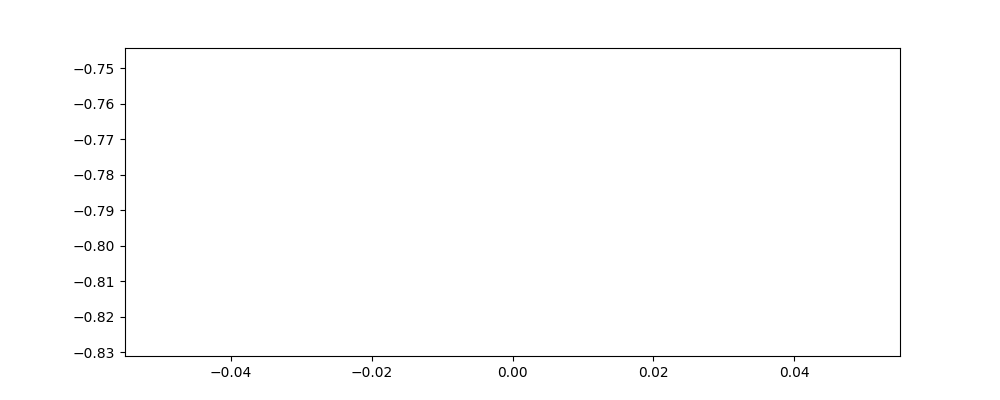

In [33]:
fig ,ax = plt.subplots(figsize=(10,4))

for i in range(1):
    ax.plot(cpa_reverse.results[i].get())

In [ ]:
checks[37]

False